In [240]:
import os
import pandas as pd
import numpy as np
import quantstats as qs
from typing import Dict
import datetime as dt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
########## Parameters class 
####Core principals to be decided once and not changed through out the strategy

# 30 mins ORB
# enter a spread on either side which is tested first


class Params():
    def __init__(self) -> None:
    # Non changeable parameters
        self.Period = "30 mins"
        self.strike_chng = 5
        self.lot_size = 100
        self.ref_atm = 0
        self.ref_time = None
        self.period_high = 0
        self.period_low = 0 
        self.start_ORB_time = dt.time(9,31)
        self.end_ORB_time = dt.time(10)
        self.entry_time = dt.time(9,45)
        self.max_lots = 0
        self.net_credit = 0
        self.sid = 1
        self.enter_spread = False
        self.enter_condor = False
        


    # Changeable parameters
        self.strikes_away = 15
        self.strategy_stoploss = 0
        self.square_off_time = dt.time(15)
        self.condor_pnl = 0
        self.spread_pnl = 0
        self.realised_pnl = 0
        self.unrealised_pnl = 0
        self.ORB_range = 0


class Single_leg():
    def __init__(self):
        self.strike = 0
        self.bs = 0
        self.status = 0
        self.open_px = 0
        self.close_px = 0
        self.open_time = 0
        self.close_time = 0
        self.lots = 0
        self.m2m = 0


class Condor():
    def __init__(self) -> None:
        self.atm_strike = 0
        self.call_sell = Single_leg()
        self.put_sell = Single_leg()
        self.call_buy = Single_leg()
        self.put_buy = Single_leg()
        self.condor_status = 0
        self.net_credit = 0
        self.max_loss = 0
        self.max_profit = 0

class Vertical_spread():
    def __init__(self) -> None:
        self.atm_strike = 0
        self.opt_type = ""
        self.sell_leg = Single_leg()
        self.buy_leg = Single_leg() 
        self.spread_status = 0
        self.max_loss = 0
        self.max_profit = 0
        self.net_credit = 0
        

class Position():
    def __init__(self) -> None:
        self.sid = 0
        self.open_time = None
        self.condor = Condor()
        self.spread = Vertical_spread()


        # Condor params
        
class OHLC():
    def __init__(self):
        self.df = None
        self.timeframe = 0

    def making_ohlc(self,df,timeframe):
        self.df = df
        self.timeframe = timeframe

        
        self.df = self.df.resample(timeframe,
                                origin = "start",
                                offset = "0min").agg({"undLtp": ["first","max","min","last"]})
        self.df.columns = ["Open","High","Low","Close"]

        return self.df
        


In [242]:
#### Model Functions ###
def check_orb_breakout(ohlc_df,orb_high,orb_low,end_orb_time,square_off_time):

    for i in range(len(ohlc_df) - 2):
        curr_time = ohlc_df.index[i].time()

        if curr_time > end_orb_time and curr_time < square_off_time:
            close = ohlc_df.iloc[i]['Close']
            next_close = ohlc_df.iloc[i+1]['Close']
            entry_time = ohlc_df.index[i+2].time() 

            if close > (orb_high + 2)  and next_close > (orb_high + 2):
                return True, "PUT", entry_time

            elif close < (orb_low - 2) and next_close < (orb_low - 2 ):
                return True, 'CALL', entry_time
            
    return False, None , None



In [297]:
instrument = "SPXW"
years = [2024,2025]
months = ["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
# months = ["AUG"]
all_positions = []

for year in years:
    for mnth in months:
        path = r"D:\USER_DATA\Desktop\Data For testing\US Master Data\SPXW\{}\{}".format(year,mnth)
        check_dates = []
        dirlist = os.listdir(path)
        # dirlist = dirlist[0:1]
        for files in dirlist:
            file = files.replace(".feather","")
        
            path = r"D:\USER_DATA\Desktop\Data For testing\US Master Data\SPXW\{}\{}\{}.feather".format(year,mnth,file)
            print(f"\n file {file}")
            df = pd.read_feather(path)
        
            model_params = Params()
            positions_map:Dict[int,Position] = {}
            
            ohlc = OHLC()
            ohlc_df = ohlc.making_ohlc(df,"1min")

            for idx in df.itertuples():
                try:
                    curr_time  = idx.Index.time()
                    undltp = idx.undLtp
                    
                    if model_params.start_ORB_time < curr_time < model_params.end_ORB_time:
                        if model_params.period_high == 0:
                            model_params.period_high = undltp
                        if undltp > model_params.period_high:
                            model_params.period_high = undltp
                        if model_params.period_low == 0:
                            model_params.period_low = undltp
                        if undltp < model_params.period_low:
                            model_params.period_low = undltp
                        model_params.ORB_range = model_params.period_high - model_params.period_low
                        # print(model_params.ORB_range)
                        

                        

                    if model_params.start_ORB_time < curr_time < model_params.square_off_time:
                        # Entering an Iron condor
                        if curr_time == model_params.entry_time:
                            model_params.ref_atm = undltp
                            atm_strike = round(model_params.ref_atm/model_params.strike_chng) * model_params.strike_chng
                            model_params.ref_atm = atm_strike
                            model_params.enter_condor = True

                            if model_params.enter_condor:
                                sid = model_params.sid
                                positions_map[sid] = Position()
                                pos = positions_map[sid] 
                                pos.open_time = idx.Index
                                pos.condor.atm_strike = model_params.ref_atm
                                pos.condor.condor_status = 1
                                pos.condor.call_sell.strike = pos.condor.atm_strike + 15
                                print(f"Condor Call sell strike {pos.condor.call_sell.strike}")
                                try:
                                    pos.condor.call_sell.open_px = getattr(idx,f"C_{positions_map[sid].condor.call_sell.strike}_bid")
                                except:
                                    pos.condor.call_sell.open_px = getattr(idx,f"C_{positions_map[sid].condor.call_sell.strike}_mid")
                                pos.condor.call_sell.bs = 2
                                pos.condor.call_sell.lots = 1
                                pos.condor.call_sell.status = 1

                                pos.condor.put_sell.strike = pos.condor.atm_strike - 15
                                print(f"Condor Put sell strike {pos.condor.put_sell.strike}")
                                pos.condor.put_sell.open_px = getattr(idx,f"P_{positions_map[sid].condor.put_sell.strike}_bid")
                                pos.condor.put_sell.bs = 2
                                pos.condor.put_sell.lots = 1
                                pos.condor.put_sell.status = 1

                                pos.condor.call_buy.strike = pos.condor.call_sell.strike + 10
                                print(f"Condor Call buy strike {pos.condor.call_buy.strike}")
                                pos.condor.call_buy.open_px = getattr(idx,f"C_{positions_map[sid].condor.call_buy.strike}_ask")
                                print(f"\n call buy open px {pos.condor.call_buy.open_px}")
                                pos.condor.call_buy.bs = 1
                                pos.condor.call_buy.lots = 1
                                pos.condor.call_buy.status = 1

                                pos.condor.put_buy.strike = pos.condor.put_sell.strike - 10
                                print(f"Condor put buy strike {pos.condor.put_buy.strike}")
                                pos.condor.put_buy.open_px = getattr(idx,f"P_{positions_map[sid].condor.put_buy.strike}_ask")
                                pos.condor.put_buy.bs = 1
                                pos.condor.put_buy.lots = 1
                                pos.condor.put_buy.status = 1

                                pos.condor.net_credit = (pos.condor.call_sell.open_px + pos.condor.put_sell.open_px - pos.condor.call_buy.open_px - pos.condor.put_buy.open_px )
                                call_spread = (pos.condor.call_buy.strike - pos.condor.call_sell.strike)
                                put_spread = (pos.condor.put_sell.strike - pos.condor.put_buy.strike)
                                pos.condor.max_loss = ((call_spread - pos.condor.net_credit) * -model_params.lot_size) + ((put_spread - pos.condor.net_credit) * -model_params.lot_size)
                                pos.condor.max_profit = pos.condor.net_credit * 100
                                
                                model_params.sid += 1


                            confirmed, side, entry_time = check_orb_breakout(
                                ohlc_df,model_params.period_high,model_params.period_low,model_params.end_ORB_time,model_params.square_off_time)
                            
                            if confirmed and model_params.enter_spread == False:
                                print(f"Breakout {side}, enter at {entry_time}")

                                ## Entering spread
                                sid = model_params.sid
                                positions_map[sid] = Position()
                                pos = positions_map[sid] 
                                pos.open_time = idx.Index
                                pos.spread.spread_status = 1
                                if side == "CALL":
                                    pos.spread.opt_type = "C"
                                    pos.spread.sell_leg.strike = model_params.ref_atm + 15
                                    print(f"\nspread {side} sell leg {pos.spread.sell_leg.strike}")
                                    pos.spread.sell_leg.open_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.sell_leg.strike}_bid")
                                    pos.spread.sell_leg.lots = 1
                                    pos.spread.sell_leg.bs = 2

                                    pos.spread.buy_leg.strike = pos.spread.sell_leg.strike + 10
                                    print(f"spread {side} buy leg {pos.spread.buy_leg.strike}")
                                    pos.spread.buy_leg.open_px =  getattr(idx,f"{pos.spread.opt_type}_{pos.spread.buy_leg.strike}_ask")
                                    pos.spread.buy_leg.bs = 1
                                    pos.spread.buy_leg.lots = 1

                                    pos.spread.net_credit = (pos.spread.sell_leg.open_px - pos.spread.buy_leg.open_px )
                                    pos.spread.max_loss = (((pos.spread.buy_leg.strike - pos.spread.sell_leg.strike) - pos.spread.net_credit) * -model_params.lot_size)
                                    pos.spread.max_profit = pos.spread.net_credit * 100

                                if side == "PUT":
                                    pos.spread.opt_type = "P"
                                    pos.spread.sell_leg.strike = model_params.ref_atm - 15
                                    print(f"\nspread {side} sell leg {pos.spread.sell_leg.strike}")
                                    pos.spread.sell_leg.open_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.sell_leg.strike}_bid")
                                    pos.spread.sell_leg.lots = 1
                                    pos.spread.sell_leg.bs = 2

                                    pos.spread.buy_leg.strike = pos.spread.sell_leg.strike - 10
                                    print(f"spread {side} buy leg {pos.spread.buy_leg.strike}")
                                    pos.spread.buy_leg.open_px =  getattr(idx,f"{pos.spread.opt_type}_{pos.spread.buy_leg.strike}_ask")
                                    pos.spread.buy_leg.bs = 1
                                    pos.spread.buy_leg.lots = 1

                                    
                                    pos.spread.net_credit = (pos.spread.sell_leg.open_px - pos.spread.buy_leg.open_px )
                                    pos.spread.max_loss = (((pos.spread.sell_leg.strike - pos.spread.buy_leg.strike) - pos.spread.net_credit) * -model_params.lot_size)
                                    pos.spread.max_profit = pos.spread.net_credit * 100

                                model_params.enter_spread =  True

                    condor_pnl = 0
                    model_params.condor_pnl = 0
                    spread_pnl = 0
                    model_params.spread_pnl = 0
                    for sid, pos in positions_map.items():
                        if pos.condor.condor_status == 1 and curr_time < model_params.square_off_time:
                            if pos.condor.call_sell.status == 1:
                                call_sell_ltp = getattr(idx,f"C_{pos.condor.call_sell.strike}_bid")
                                pos.condor.call_sell.m2m = (pos.condor.call_sell.open_px - call_sell_ltp) * pos.condor.call_sell.lots * model_params.lot_size
                            else:
                                pos.condor.call_sell.m2m = (pos.condor.call_sell.open_px - pos.condor.call_sell.close_px) * pos.condor.call_sell.lots * model_params.lot_size

                            if pos.condor.put_sell.status == 1:
                                put_sell_ltp = getattr(idx,f"P_{pos.condor.put_sell.strike}_bid")
                                pos.condor.put_sell.m2m = (pos.condor.put_sell.open_px - put_sell_ltp) * pos.condor.put_sell.lots * model_params.lot_size
                            else:
                                pos.condor.put_sell.m2m = (pos.condor.put_sell.open_px - pos.condor.put_sell.close_px) *  pos.condor.put_sell.lots * model_params.lot_size

                            if pos.condor.call_buy.status == 1:
                                call_buy_ltp = getattr(idx,f"C_{pos.condor.call_buy.strike}_ask")
                                pos.condor.call_buy.m2m = (call_buy_ltp - pos.condor.call_buy.open_px) * pos.condor.call_buy.lots * model_params.lot_size
                            else:
                                pos.condor.call_buy.m2m = (pos.condor.call_buy.close_px - pos.condor.call_buy.open_px ) * pos.condor.call_buy.lots * model_params.lot_size
                            if pos.condor.put_buy.status == 1:
                                put_buy_ltp = getattr(idx,f"P_{pos.condor.put_buy.strike}_ask")
                                pos.condor.put_buy.m2m = (put_buy_ltp - pos.condor.put_buy.open_px) * pos.condor.put_buy.lots * model_params.lot_size
                            else:
                                pos.condor.put_buy.m2m = (pos.condor.put_buy.close_px - pos.condor.put_buy.open_px ) * pos.condor.put_buy.lots * model_params.lot_size

                            condor_pnl = (pos.condor.call_sell.m2m + pos.condor.put_sell.m2m + pos.condor.call_buy.m2m + pos.condor.put_buy.m2m) 
                            model_params.condor_pnl += (condor_pnl) 
                            # print(f"condor pnl {model_params.condor_pnl * model_params.lot_size} curr time {curr_time}")
                                
                        if pos.spread.spread_status == 1 and curr_time < model_params.square_off_time:
                            if pos.spread.sell_leg.status == 1:
                                sell_ltp = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.sell_leg.strike}_bid")
                                pos.spread.sell_leg.m2m = (pos.spread.sell_leg.open_px - sell_ltp) * pos.spread.sell_leg.lots * model_params.lot_size
                            else:
                                pos.spread.sell_leg.m2m = (pos.spread.sell_leg.open_px - pos.spread.sell_leg.close_px) * pos.spread.sell_leg.lots * model_params.lot_size

                            if pos.spread.buy_leg.status == 1:
                                buy_ltp = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.buy_leg.strike}_ask")
                                pos.spread.buy_leg.m2m = (buy_ltp - pos.spread.buy_leg.open_px) * pos.spread.buy_leg.lots * model_params.lot_size
                            else:
                                pos.spread.buy_leg.m2m = (pos.spread.buy_leg.close_px - pos.spread.buy_leg.open_px ) * pos.spread.buy_leg.lots * model_params.lot_size

                            spread_pnl = pos.spread.buy_leg.m2m + pos.spread.sell_leg.m2m
                            model_params.spread_pnl += spread_pnl 


                    for sid, pos in positions_map.items():
                        
                        if undltp > pos.condor.call_sell.strike and pos.condor.call_buy.lots < 2 and sid == 1 and pos.condor.condor_status == 1:
                            pos.condor.call_buy.lots += 1
                            pos.condor.call_buy.open_px = (pos.condor.call_buy.open_px + getattr(idx,f"C_{pos.condor.call_buy.strike}_ask"))/2
                            # print(f"\nUpdated call buy open px {pos.condor.call_buy.open_px} lots {pos.condor.call_buy.lots}")
                            
                        if undltp < pos.condor.put_sell.strike and pos.condor.put_buy.lots < 2 and sid == 1 and pos.condor.condor_status == 1:
                            pos.condor.put_buy.lots += 1
                            pos.condor.put_buy.open_px = (pos.condor.put_buy.open_px + getattr(idx,f"P_{pos.condor.put_buy.strike}_ask"))/2
                            # print(f"\nUpdated put buy open px {pos.condor.put_buy.open_px} lots {pos.condor.put_buy.lots}")

                      
                        if model_params.spread_pnl <= pos.spread.max_loss and sid == 2 :
                            if pos.spread.spread_status == 1:
                                if pos.spread.opt_type == "C":
                                    pos.spread.sell_leg.close_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.sell_leg.strike}_bid")
                                    pos.spread.sell_leg.close_time = curr_time
                                    pos.spread.sell_leg.status = 0

                                    pos.spread.buy_leg.close_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.buy_leg.strike}_ask")
                                    pos.spread.buy_leg.close_time = curr_time
                                    pos.spread.buy_leg.status = 0
                                    pos.spread.spread_status = 0

                                if pos.spread.opt_type == "P":
                                    pos.spread.sell_leg.close_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.sell_leg.strike}_bid")
                                    pos.spread.sell_leg.close_time = curr_time
                                    pos.spread.sell_leg.status = 0

                                    pos.spread.buy_leg.close_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.buy_leg.strike}_ask")
                                    pos.spread.buy_leg.close_time = curr_time
                                    pos.spread.buy_leg.status = 0
                                    pos.spread.spread_status = 0
     
                            
                        if model_params.condor_pnl <= (pos.condor.max_loss * 0.50)  and sid == 1 and model_params.ORB_range > 15:

                            if pos.condor.condor_status == 1:
                                pos.condor.call_sell.close_px = getattr(idx,f"C_{pos.condor.call_sell.strike}_ask")
                                pos.condor.call_sell.status = 0
                                pos.condor.call_sell.close_time = curr_time
                                
                                pos.condor.call_buy.close_px = getattr(idx,f"C_{pos.condor.call_buy.strike}_bid")
                                pos.condor.call_buy.status = 0
                                pos.condor.call_buy.close_time = curr_time

                                pos.condor.put_sell.close_px = getattr(idx,f"P_{pos.condor.put_sell.strike}_ask")
                                pos.condor.put_sell.status = 0
                                pos.condor.put_sell.close_time = curr_time
                                
                                pos.condor.put_buy.close_px = getattr(idx,f"P_{pos.condor.put_buy.strike}_bid")
                                pos.condor.put_buy.status = 0
                                pos.condor.put_buy.close_time = curr_time

                                pos.condor.condor_status = 0
                                print(f"Condor sqaured off @ {curr_time} loss was {model_params.condor_pnl} max loss allowed {pos.condor.max_loss}")
                                
                        elif model_params.condor_pnl <= (pos.condor.max_loss) and sid == 1 and model_params.ORB_range < 15:
                            if pos.condor.condor_status == 1:
                                pos.condor.call_sell.close_px = getattr(idx,f"C_{pos.condor.call_sell.strike}_ask")
                                pos.condor.call_sell.status = 0
                                pos.condor.call_sell.close_time = curr_time
                                
                                pos.condor.call_buy.close_px = getattr(idx,f"C_{pos.condor.call_buy.strike}_bid")
                                pos.condor.call_buy.status = 0
                                pos.condor.call_buy.close_time = curr_time

                                pos.condor.put_sell.close_px = getattr(idx,f"P_{pos.condor.put_sell.strike}_ask")
                                pos.condor.put_sell.status = 0
                                pos.condor.put_sell.close_time = curr_time
                                
                                pos.condor.put_buy.close_px = getattr(idx,f"P_{pos.condor.put_buy.strike}_bid")
                                pos.condor.put_buy.status = 0
                                pos.condor.put_buy.close_time = curr_time

                                pos.condor.condor_status = 0

                        
                        if curr_time >= model_params.square_off_time  :
                            if pos.condor.condor_status == 1:
                                pos.condor.call_sell.close_px = getattr(idx,f"C_{pos.condor.call_sell.strike}_ask")
                                pos.condor.call_sell.status = 0
                                pos.condor.call_sell.close_time = curr_time
                                
                                pos.condor.call_buy.close_px = getattr(idx,f"C_{pos.condor.call_buy.strike}_bid")
                                pos.condor.call_buy.status = 0
                                pos.condor.call_buy.close_time = curr_time

                                pos.condor.put_sell.close_px = getattr(idx,f"P_{pos.condor.put_sell.strike}_ask")
                                pos.condor.put_sell.status = 0
                                pos.condor.put_sell.close_time = curr_time
                                
                                pos.condor.put_buy.close_px = getattr(idx,f"P_{pos.condor.put_buy.strike}_bid")
                                pos.condor.put_buy.status = 0
                                pos.condor.put_buy.close_time = curr_time

                                pos.condor.condor_status = 0

                            if pos.spread.spread_status == 1:
                                if pos.spread.opt_type == "C":
                                    pos.spread.sell_leg.close_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.sell_leg.strike}_bid")
                                    pos.spread.sell_leg.close_time = curr_time
                                    pos.spread.sell_leg.status = 0

                                    pos.spread.buy_leg.close_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.buy_leg.strike}_ask")
                                    pos.spread.buy_leg.close_time = curr_time
                                    pos.spread.buy_leg.status = 0
                                    pos.spread.spread_status = 0

                                if pos.spread.opt_type == "P":
                                    pos.spread.sell_leg.close_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.sell_leg.strike}_bid")
                                    pos.spread.sell_leg.close_time = curr_time
                                    pos.spread.sell_leg.status = 0

                                    pos.spread.buy_leg.close_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.buy_leg.strike}_ask")
                                    pos.spread.buy_leg.close_time = curr_time
                                    pos.spread.buy_leg.status = 0
                                    pos.spread.spread_status = 0
                except AttributeError:
                    print(f"Missing data for {file}, skipping this day")
                    break
            all_positions.append(positions_map)
        
                
        
                       
                       



 file 02-01-2024
Condor Call sell strike 4750
Condor Put sell strike 4720
Condor Call buy strike 4760

 call buy open px 1.9
Condor put buy strike 4710
Breakout CALL, enter at 10:33:01

spread CALL sell leg 4750
spread CALL buy leg 4760

 file 03-01-2024
Condor Call sell strike 4735
Condor Put sell strike 4705
Condor Call buy strike 4745

 call buy open px 1.9
Condor put buy strike 4695
Breakout PUT, enter at 10:07:01

spread PUT sell leg 4705
spread PUT buy leg 4695

 file 04-01-2024
Condor Call sell strike 4720
Condor Put sell strike 4690
Condor Call buy strike 4730

 call buy open px 1.55
Condor put buy strike 4680
Breakout PUT, enter at 10:03:01

spread PUT sell leg 4690
spread PUT buy leg 4680

 file 05-01-2024
Condor Call sell strike 4715
Condor Put sell strike 4685
Condor Call buy strike 4725

 call buy open px 2.05
Condor put buy strike 4675
Breakout PUT, enter at 10:02:01

spread PUT sell leg 4685
spread PUT buy leg 4675

 file 08-01-2024
Condor Call sell strike 4720
Condor P

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\USER_DATA\\Desktop\\Data For testing\\US Master Data\\SPXW\\2025\\SEP'

In [298]:
# After your loop ends (after building all_positions):

# Flatten into list of dicts
data_dicts = []
for pos_map in all_positions:              # each pos_map is a dict {sid: Position()}
    for sid, pos in pos_map.items():
        call_sell_pnl = ((pos.condor.call_sell.open_px - pos.condor.call_sell.close_px) * pos.condor.call_sell.lots) * model_params.lot_size
        put_sell_pnl = ((pos.condor.put_sell.open_px - pos.condor.put_sell.close_px) * pos.condor.put_sell.lots) * model_params.lot_size
        call_buy_pnl = ((pos.condor.call_buy.close_px - pos.condor.call_buy.open_px) * pos.condor.call_buy.lots) * model_params.lot_size
        put_buy_pnl = ((pos.condor.put_buy.close_px - pos.condor.put_buy.open_px) * pos.condor.put_buy.lots) * model_params.lot_size
        # turn condor data into dict
        condor_dict = {}
        if hasattr(pos, "condor"):
            condor_dict = {
                "sid": sid,
                "condor_open_time": pos.open_time,
                "condor_atm_strike": pos.condor.atm_strike,
                "condor_net_credit": pos.condor.net_credit,
                "condor_max_loss": pos.condor.max_loss,
                "condor_max_profit": pos.condor.max_profit,
                "call_sell_strike": pos.condor.call_sell.strike,
                "call_sell_open_px": pos.condor.call_sell.open_px,
                "call_sell_close_px": pos.condor.call_sell.close_px,
                "put_sell_strike": pos.condor.put_sell.strike,
                "put_sell_open_px": pos.condor.put_sell.open_px,
                "put_sell_close_px": pos.condor.put_sell.close_px,
                "call_buy_strike": pos.condor.call_buy.strike,
                "call_buy_open_px": pos.condor.call_buy.open_px,
                "call_buy_close_px": pos.condor.call_buy.close_px,
                "call_sell_lots" : pos.condor.call_sell.lots,
                "put_buy_lots": pos.condor.put_buy.lots,
                "put_sell_lots" : pos.condor.put_sell.lots,
                "call_buy_lots" : pos.condor.call_buy.lots,
                "put_buy_strike": pos.condor.put_buy.strike,
                "put_buy_open_px": pos.condor.put_buy.open_px,
                "put_buy_close_px": pos.condor.put_buy.close_px,
                "condor_close_time" : pos.condor.call_sell.close_time, 
                "status " : pos.condor.condor_status,
                "condor_pnl" : round(call_sell_pnl + put_sell_pnl + call_buy_pnl + put_buy_pnl,2),
                "condor_call_close_tm": pos.condor.call_sell.close_time,
                "condor,put_close,tm" : pos.condor.put_sell.close_time
                # "condor_day_pnl" : (((pos.condor.call_sell.open_px - pos.condor.call_sell.close_px) * pos.condor.call_sell.lots) 
                #                     + ((pos.condor.put_sell.open_px - pos.condor.put_sell.close_px) * pos.condor.put_sell.lots)
                #              + ((pos.condor.call_buy.close_px - pos.condor.call_buy.open_px) * pos.condor.call_buy.lots) 
                #              + ((pos.condor.put_buy.close_px - pos.condor.put_buy.open_px) * pos.condor.put_buy.lots) ) * 100 
            }

        # turn spread data into dict
        spread_dict = {}
        if hasattr(pos, "spread"):
            spread_dict = {
                "spread_open_time": pos.open_time,
                "spread_opt_type": pos.spread.opt_type,
                "spread_net_credit": pos.spread.net_credit,
                "spread_max_loss": pos.spread.max_loss,
                "spread_max_profit": pos.spread.max_profit,
                "spread_sell_strike": pos.spread.sell_leg.strike,
                "spread_sell_open_px": pos.spread.sell_leg.open_px,
                "spread_sell_close_px": pos.spread.sell_leg.close_px,
                "spread_buy_strike": pos.spread.buy_leg.strike,
                "spread_buy_open_px": pos.spread.buy_leg.open_px,
                "spread_buy_close_px": pos.spread.buy_leg.close_px,
                "status" : pos.spread.spread_status,
                "close_time" : pos.spread.sell_leg.close_time,
                "day_pnl" : ((pos.spread.sell_leg.open_px - pos.spread.sell_leg.close_px) + (pos.spread.buy_leg.close_px - pos.spread.buy_leg.open_px) ) * 100
            }

        # merge
        merged = {**condor_dict, **spread_dict}
        if merged:   # only append if something exists
            data_dicts.append(merged)

# Convert to DataFrame
df_trades = pd.DataFrame(data_dicts)

# Optional: set index
if "condor_open_time" in df_trades.columns:
    df_trades = df_trades.set_index("condor_open_time")

print(df_trades['condor_max_loss'].min())
print(df_trades["spread_max_loss"].min())
df_trades

-1639.999999999999
-939.9999999999999


,sid,condor_atm_strike,condor_net_credit,condor_max_loss,condor_max_profit,call_sell_strike,call_sell_open_px,call_sell_close_px,put_sell_strike,put_sell_open_px,...,spread_max_profit,spread_sell_strike,spread_sell_open_px,spread_sell_close_px,spread_buy_strike,spread_buy_open_px,spread_buy_close_px,status,close_time,day_pnl
condor_open_time,,,,,,,,,,,,,,,,,,,,,
2024-01-02 09:45:00,1,4735,3.75,-1250.0,375.0,4750,4.0,0.15,4720,3.4,...,0.0,0,0.0,0.00,0,0.00,0.00,0,0,0.0
2024-01-02 09:45:00,2,0,0.00,0.0,0.0,0,0.0,0.00,0,0.0,...,210.0,4750,4.0,0.10,4760,1.90,0.10,0,15:00:00,210.0
2024-01-03 09:45:00,1,4720,4.25,-1150.0,425.0,4735,4.0,0.60,4705,4.3,...,0.0,0,0.0,0.00,0,0.00,0.00,0,0,0.0
2024-01-03 09:45:00,2,0,0.00,0.0,0.0,0,0.0,0.00,0,0.0,...,215.0,4705,4.3,0.60,4695,2.15,0.20,0,15:00:00,175.0
2024-01-04 09:45:00,1,4705,3.50,-1300.0,350.0,4720,3.6,0.30,4690,2.9,...,0.0,0,0.0,0.00,0,0.00,0.00,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-04 09:45:00,2,0,0.00,0.0,0.0,0,0.0,0.00,0,0.0,...,240.0,6285,8.8,0.25,6275,6.40,0.25,0,15:00:00,240.0
2025-08-05 09:45:00,1,6340,4.20,-1160.0,420.0,6355,4.7,0.05,6325,6.7,...,0.0,0,0.0,0.00,0,0.00,0.00,0,0,0.0
2025-08-05 09:45:00,2,0,0.00,0.0,0.0,0,0.0,0.00,0,0.0,...,220.0,6355,4.7,0.00,6365,2.50,0.05,0,15:00:00,225.0


In [173]:
print(df_trades.to_markdown())

| condor_open_time    |   sid |   condor_atm_strike |   condor_net_credit |   condor_max_loss |   condor_max_profit |   call_sell_strike |   call_sell_open_px |   call_sell_close_px |   put_sell_strike |   put_sell_open_px |   put_sell_close_px |   call_buy_strike |   call_buy_open_px |   call_buy_close_px |   call_sell_lots |   put_buy_lots |   put_sell_lots |   call_buy_lots |   put_buy_strike |   put_buy_open_px |   put_buy_close_px | condor_close_time   |   status  |   condor_pnl | condor_call_close_tm   | condor,put_close,tm   | spread_open_time    | spread_opt_type   |   spread_net_credit |   spread_max_loss |   spread_max_profit |   spread_sell_strike |   spread_sell_open_px |   spread_sell_close_px |   spread_buy_strike |   spread_buy_open_px |   spread_buy_close_px |   status | close_time   |   day_pnl |
|:--------------------|------:|--------------------:|--------------------:|------------------:|--------------------:|-------------------:|--------------------:|---------------

In [299]:
df_trades['date'] = pd.to_datetime(df_trades.index).date
df_trades2 = df_trades[['date',"day_pnl","condor_pnl"]]
df_trades2 = df_trades2.groupby('date').agg("sum").reset_index()
df_trades2 = df_trades2.set_index('date')
# df_trades2
df_trades2["combined_pnl"] = round(df_trades2["day_pnl"] + df_trades2["condor_pnl"],3)
print(df_trades2.combined_pnl.sum())
df_trades2


37369.5


,day_pnl,condor_pnl,combined_pnl
date,,,
2024-01-02,210.0,-30.0,180.0
2024-01-03,175.0,-100.0,75.0
2024-01-04,130.0,35.0,165.0
2024-01-05,-65.0,-690.0,-755.0
2024-01-08,145.0,1455.0,1600.0
...,...,...,...
2025-07-22,145.0,-395.0,-250.0
2025-08-01,275.0,-390.0,-115.0
2025-08-04,240.0,-440.0,-200.0


In [301]:
df_trades2.to_csv(fr"D:\Python\pythonproject\US market\Us-market\Strategy1\CSV's\CSV for strategy 1.csv")

In [231]:
print(df_trades2.to_markdown())

| date                |   day_pnl |   condor_pnl |   combined_pnl |   return |
|:--------------------|----------:|-------------:|---------------:|---------:|
| 2024-01-02 00:00:00 |       210 |        -30   |          180   |  0.0036  |
| 2024-01-03 00:00:00 |       175 |       -100   |           75   |  0.0015  |
| 2024-01-04 00:00:00 |       130 |         35   |          165   |  0.0033  |
| 2024-01-05 00:00:00 |       -65 |       -690   |         -755   | -0.0151  |
| 2024-01-08 00:00:00 |       145 |       1455   |         1600   |  0.032   |
| 2024-01-09 00:00:00 |       170 |       -330   |         -160   | -0.0032  |
| 2024-01-10 00:00:00 |      -320 |        -85   |         -405   | -0.0081  |
| 2024-01-11 00:00:00 |       185 |       -470   |         -285   | -0.0057  |
| 2024-01-12 00:00:00 |       210 |       -545   |         -335   | -0.0067  |
| 2024-01-16 00:00:00 |       180 |       -115   |           65   |  0.0013  |
| 2024-01-17 00:00:00 |       210 |        150   |  

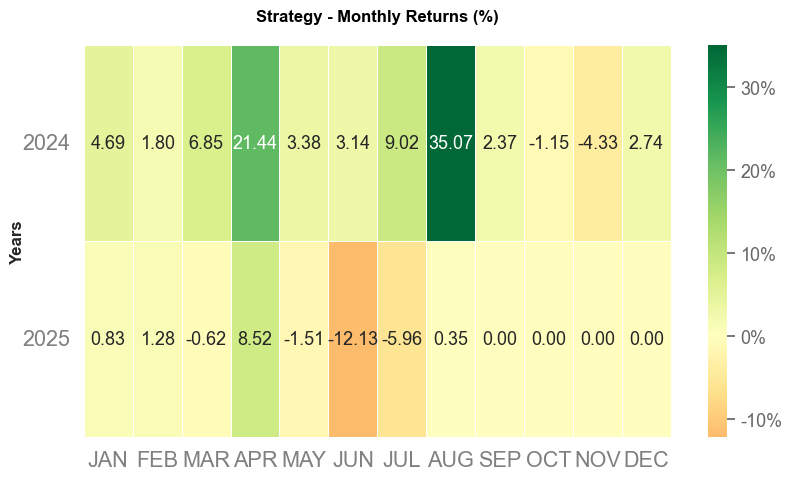

In [302]:
df_trades2.index = pd.to_datetime(df_trades2.index)
df_trades2["return"] = df_trades2["combined_pnl"]/50000
qs.plots.monthly_heatmap(df_trades2["return"])
qs.reports.html(df_trades2["return"],output= fr"D:\Python\pythonproject\US market\Us-market\Strategy1\Tearsheets\Tearsheet for strategy1.html" )

In [177]:
fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Ohlc(x = ohlc_df.index , open = ohlc_df["Open"]
                               ,high = ohlc_df["High"] , low = ohlc_df['Low'],
                               close = ohlc_df["Close"]), secondary_y=False)

fig.add_hline(y = model_params.period_high)
fig.add_hline(y = model_params.period_low)
# call_line = df1.CE_5990_0_W_ltp.resample("2min").mean().reindex(ohlc_df.index,method = "ffill")
# put_line = df1.PE_6000_0_W_ltp.resample("2min").mean().reindex(ohlc_df.index,method = "ffill")

# fig.add_trace(go.Scatter(x = ohlc_df.index,y = call_line,mode="lines",line=dict(color="blue", width=1)), secondary_y=True)
# fig.add_trace(go.Scatter(x = ohlc_df.index,y = put_line,mode="lines",line=dict(color="green", width=1)), secondary_y=True)
fig.update_layout(
    title="OHLC Chart ",
    xaxis_title="Date",
    yaxis_title="Price",
    xaxis_rangeslider_visible=False # hides the range slider
)

fig.show()
